#### import libraries

In [1]:
# Load the packages
from requests_html import AsyncHTMLSession
import requests
from bs4 import BeautifulSoup
import pandas as pd
# importing pyppdf library to download chromium (just for the first time)
import pyppdf.patch_pyppeteer

#### build the url

In [3]:
# defining a function to build all the urls function of the maker, model,startYear, endYear, province, city and the number of pages we want to scrap
def urls_maker(number_of_pages):
    #defining the url depending of car maker, model, start year, end year, province and city
    make=input("enter maker: ")
    model = input("enter model: ")
    startYear = input("enter start year: ")
    endYear = input("enter end year: ")
    province = input("enter province: ")
    city = input("enter city: ")
    urls = []
    
    for i in range(0,number_of_pages):
        # when startYear and endYear are equal the structure of the url is different so we have to take it into consideration
        if startYear != endYear:
            header = "http://www.autotrader.ca/cars/"+make+"/"+model+"/"+province+"/"+city
            trailer = "/?rcp=15"+"&rcs="+str(15*i)+"&srt=4&yRng="+startYear+"%2C"+endYear
            urls.append(header+trailer)
        else:
            header = "http://www.autotrader.ca/cars/"+make+"/"+model+"/"+startYear+"/"+province+"/"+city
            trailer = "/?rcp=15&rcs="+str(15*i)+"&srt=4"
            urls.append(header+trailer)
        
    
    return make,model,startYear,endYear,province,city,urls

In [4]:
# executing the url_maker function and storing outputs into a variable called info
info = urls_maker(5)

enter maker:  honda
enter model:  cr-v
enter start year:  2014
enter end year:  2020
enter province:  on
enter city:  toronto


- now we have built the url, we can start scraping the information about vehicles 

#### webscraping

In [5]:
i=0
# creating empty lists for each feature that we need
link = []
mile = []
detail = []
ad_title = []
car_price = []
market_delta = []
car_type = []
cur = []
for url in info[-1]:
    session = AsyncHTMLSession()
    r = await session.get(url)
    print(i,r.status_code, end=" , ")
    if r.status_code==200:
        # getting the HTML from the webpage
        html = r.content
        # converting the HTML to a Beautiful Soup object
        soup = BeautifulSoup(html, 'lxml')
        
        
        ####### extracting elements
        
        #### listing details are in div tags and listing-details class
        listing_details = soup.find_all("div",{"class":"listing-details"})
        
        # absolute link (we have the relative link in a tags and click class then we have to add before the link's root "https://autotrader.ca")
        links = ["https://autotrader.ca"+link.find("a",{"class":"click"})["href"]
                 if link.find("a",{"class":"click"}) is not None else link.find("a",{"class":"click"}) for link in listing_details]
        link.extend(links)
        # mileage
        mileage = [listing_detail.find("div",{"class":"kms"}).text if listing_detail.find("div",{"class":"kms"})
               is not None else listing_detail.find("div",{"class":"kms"})for listing_detail in listing_details]
        # cleaning the extracted text to keep only the mileage in an interger format
        mileage_cleaned = [mile.split(" ")[1].replace(",","") if mile is not None else mile for mile in mileage]
        mile.extend(mileage_cleaned)
        # detail-used (text summarizing car's features)
        detail_used = [listing_detail.find("p",{"class":"details used"}).text if listing_detail.find("p",{"class":"details used"})
               is not None else listing_detail.find("p",{"class":"details used"}) for listing_detail in listing_details]
        detail.extend(detail_used)
        # ad title
        title = [listing_detail.find("span",{"itemprop":"itemOffered"}).text if listing_detail.find("span",{"itemprop":"itemOffered"})
               is not None else listing_detail.find("span",{"itemprop":"itemOffered"}) for listing_detail in listing_details]
        ad_title.extend(title)
        
        ### price info are in div tags and price-wrapper class
        price_wrapper = soup.find_all("div",{"class":"price-wrapper"})
        
        # price
        price = [price.find("span",{"class":"price-amount"}).text if price.find("span",{"class":"price-amount"})
               is not None else price.find("span",{"class":"price-amount"})for price in price_wrapper]
        # removing the $ sign using strip
        price_cleaned =[price.strip("$") for price in price]
        # removing the comma in the text before transforming it to an integer
        price_cleaned = [price.replace(",","") for price in price_cleaned]
        # transforming price to an integer instead of a string
        price_cleaned = [int(price) for price in price_cleaned]
        car_price.extend(price_cleaned)
        # delta price (vehicle price compared to the market)
        delta_price = [delta.find("p").text if delta.find("p") is not None else delta.find("p") for delta in price_wrapper]
        # finally we have to process the text in order to transform it to a positive integer when it's above the market and negative when it'S below
        delta_price_cleaned = [int(delta.strip("$").replace(",","").split(" ")[0]) if delta is not None and "Above" in delta else -int(delta.strip("$").replace(",","").split(" ")[0])
        if delta is not None and "Below" in delta else delta for delta in delta_price]
        market_delta.extend(delta_price_cleaned)
        # vehicle type (if it's a used car)
        vehicle_type = [delta.find("meta",{"itemprop":"itemCondition"})["content"] if delta.find("meta",{"itemprop":"itemCondition"}) is not None
                        else delta.find("meta",{"itemprop":"itemCondition"}) for delta in price_wrapper]
        car_type.extend(vehicle_type)
        # currency
        currency = [delta.find("meta",{"itemprop":"priceCurrency"})["content"] if delta.find("meta",{"itemprop":"priceCurrency"}) is not None
                    else delta.find("meta",{"itemprop":"priceCurrency"}) for delta in price_wrapper]
        cur.extend(currency)
        i = i + 1
    else:
        # checking the page number where the server response is not 200  
        print(i)
        break

# checking that the lists have the same length
print("length links: ",len(link))
print("length mile: ",len(mile))
print("length detail: ",len(detail))
print("length ad_title: ",len(ad_title))
print("length car_type: ",len(car_type))
print("length cur: ",len(cur))
print("length car_price: ",len(car_price))
print("length market_delta: ",len(market_delta))

0 200 , 1 200 , 2 200 , 3 200 , 4 200 , length links:  135
length mile:  135
length detail:  135
length ad_title:  135
length car_type:  135
length cur:  135
length car_price:  135
length market_delta:  135


In [6]:
# creating a dataframe containing all the information extracted previously        
database = pd.DataFrame({"link":link,"mileage":mile,"description":detail,"ad_title":ad_title,"type":car_type,"currency":cur,
                         "price":car_price,"market_delta":market_delta})
database['make'] = info[0]
database['model'] = info[1]
database['province'] = info[4]
database['city'] = info[5]

In [7]:
# extracting the year of registration of the car from the ad_title using regex
database["year"]=database["ad_title"].str.extract(r'(20[0-9]{2})')

In [8]:
# reordering the columns
database = database[["make","model","year","province","city","ad_title","description","link","mileage","type","price","currency","market_delta"]]

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

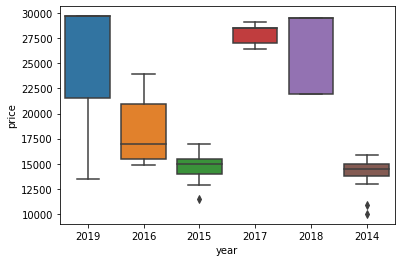

In [10]:
# let's plot a boxplot to see if there are outliers
plt.figure()
sns.boxplot(database["year"],database["price"])
plt.xticks
plt.show()

In [11]:
database.isna().sum()

make             0
model            0
year             5
province         0
city             0
ad_title         5
description      5
link             0
mileage          0
type             0
price            0
currency         0
market_delta    27
dtype: int64

In [12]:
database.shape

(135, 13)

In [13]:
import json
import re

In [ ]:
content = []
session2 = AsyncHTMLSession()
for url in database["link"]:
    try:
        r2 = await session2.get(url)
        r2.status_code
        html2 = r2.content
        soup2 =BeautifulSoup(html2,"lxml")
        dic = soup2.find_all("script",{"type":"text/javascript"})
        s = str(dic[4])
        text = re.search(r'"highlights":(.*?),"gallery"', s).group(1)
        content.append(text)
    except:
        content.append(None)
        print(url)

In [ ]:
content[11]

In [ ]:
len(database)

In [ ]:
mileage = []
transmission = []
drivetrain = []
items = []
for i in range(len(content)):
    try:
        if content[i] is not None:
            to_json=json.loads(content[i])
            if "mileage" in to_json.keys():
                mileage.append(to_json["mileage"])
            else:
                mileage.append(None)
            if "transmission" in to_json.keys():
                transmission.append(to_json["transmission"])
            else:
                transmission.append(None)
            if "drivetrain" in to_json.keys():
                drivetrain.append(to_json["drivetrain"])
            else:
                drivetrain.append(None)
            if "items" in to_json.keys():
                items.append(to_json["items"])
            else:
                items.append(None)
        else:
            mileage.append(None)
            transmission.append(None)
            drivetrain.append(None)
            items.append(None)
    except:
        print(i)
        break
        

In [39]:
session3 = AsyncHTMLSession()
r3 = await session3.get(database["link"][0])
r3.status_code
html3 = r3.content
soup3 =BeautifulSoup(html3,"lxml")
dic3 = soup3.find_all("script",{"type":"text/javascript"})
s3 = str(dic3[4])

In [15]:
text = re.search(r'"highlights":(.*?),"gallery"', s3).group(1)

In [16]:
text

'{"mileage":"32,082 km","transmission":"Automatic","drivetrain":"AWD","items":["Leather Interior","Bluetooth","Rear View Camera","Average km"]}'

In [25]:
import requests_html

In [33]:
r3.html.script

AttributeError: 'HTML' object has no attribute 'script'